
#  Structured Features per Chunk

**Goal:** Call an LLM API on each chunk from `chunks.csv` and extract **structured features** as JSON, then save a flat `features.csv` for analysis.

What I'll get per chunk:
- `primary_emotion` (e.g., joy, sadness, anger, fear, hope, admiration, neutral)
- `frames` (moral, economic, public_health, innovation, identity, environmental, scientific)
- `techniques` (storytelling, metaphor, statistic, authority, rhetorical_question, contrast, repetition, call_to_action)
- `has_call_to_action` (bool)
- `key_claims` (short list of claims, to inspect later)
- `quality_notes` (brief flags if confidence is low)


In [16]:
import os
from openai import OpenAI

client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))


In [17]:

import csv
import pandas as pd

INPUT_CSV  = "ted_talks_clean.csv"
OUTPUT_CSV = "chunks.csv"
READ_CHUNKSIZE = 200
MAX_CHARS_PER_CHUNK = 3000
OVERLAP_SENTENCES   = 2









In [18]:
def clean_text(s: str) -> str:
    if s is None: return ""
    s = str(s)
    for tag in ("[Applause]", "[Laughter]", "[Music]"):
        s = s.replace(tag, " ")
    return " ".join(s.split()).strip()

In [19]:
def split_sentences(text: str):
    text = text.strip()
    if not text: return []
    out, cur = [], []
    for ch in text:
        cur.append(ch)
        if ch in ".!?":  # end of sentence
            sent = "".join(cur).strip()
            if sent: out.append(sent)
            cur = []
    if cur:  # leftover
        last = "".join(cur).strip()
        if last: out.append(last)
    return out

In [20]:

def chunk_by_chars(text: str, max_chars=3000, overlap_sents=2):
    text  = clean_text(text)
    sents = split_sentences(text)
    if not sents: return []

    # sentence start positions
    idxs, pos = [], 0
    for s in sents:
        start = text.find(s, pos)
        idxs.append(start if start >= 0 else pos)
        pos = (start if start >= 0 else pos) + len(s)

    chunks, buf, buf_start_char, i = [], [], None, 0
    while i < len(sents):
        s = sents[i]
        if not buf:
            buf_start_char = idxs[i]
        candidate = (" ".join(buf + [s])).strip()
        if len(candidate) <= max_chars or not buf:
            buf.append(s); i += 1
        else:
            chunk_text = " ".join(buf).strip()
            start_char = buf_start_char
            end_char   = start_char + len(chunk_text)
            chunks.append((start_char, end_char, chunk_text))
            # overlap
            buf = buf[-overlap_sents:] if overlap_sents > 0 else []
            if buf:
                first_overlap = buf[0]
                new_start = text.find(first_overlap, start_char)
                buf_start_char = new_start if new_start >= 0 else end_char - len(" ".join(buf))
            else:
                buf_start_char = None

    if buf:
        chunk_text = " ".join(buf).strip()
        start_char = buf_start_char if buf_start_char is not None else 0
        end_char   = start_char + len(chunk_text)
        chunks.append((start_char, end_char, chunk_text))
    return chunks


In [21]:
#  build chunks.csv with safe quoting 
with open(OUTPUT_CSV, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f, quoting=csv.QUOTE_MINIMAL)
    w.writerow(["talk_id","chunk_id","title","speaker","start_char","end_char","n_chars","chunk_text"])

    for batch in pd.read_csv(INPUT_CSV, chunksize=READ_CHUNKSIZE):
        if "talk_id" not in batch.columns:
            batch = batch.reset_index(drop=False).rename(columns={"index":"talk_id"})
        for _, row in batch.iterrows():
            talk_id  = int(row["talk_id"])
            title    = row.get("title","")
            speaker  = row.get("speaker", row.get("speaker_1",""))
            transcript = str(row["transcript"])

            for idx, (s,e,txt) in enumerate(
                chunk_by_chars(transcript, MAX_CHARS_PER_CHUNK, OVERLAP_SENTENCES)
            ):
                if len(txt) < 20: 
                    continue
                w.writerow([talk_id, idx, title, speaker, s, e, len(txt), txt])

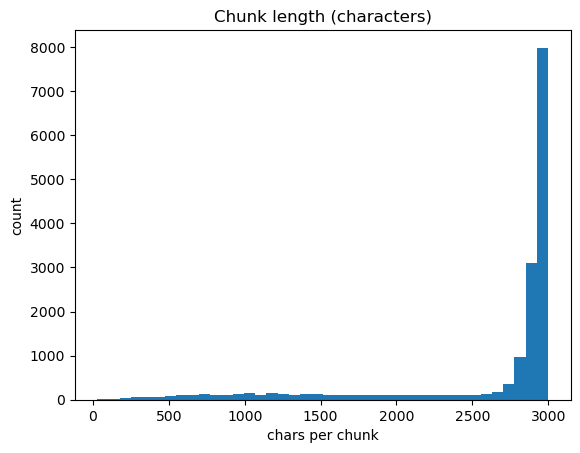

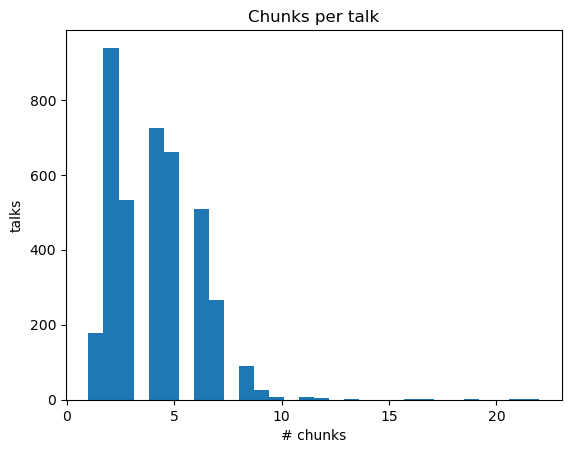

In [23]:
mini = pd.read_csv(OUTPUT_CSV, usecols=["talk_id","n_chars"])

# chunk size distribution
plt.figure()
mini["n_chars"].plot(kind="hist", bins=40)
plt.title("Chunk length (characters)")
plt.xlabel("chars per chunk"); plt.ylabel("count"); plt.show()

# chunks per talk
plt.figure()
mini.groupby("talk_id")["n_chars"].count().plot(kind="hist", bins=30)
plt.title("Chunks per talk")
plt.xlabel("# chunks"); plt.ylabel("talks"); plt.show()


In [24]:
# preview 5 random chunks
sample_chunks = pd.read_csv(OUTPUT_CSV).sample(5, random_state=42)
for _, row in sample_chunks.iterrows():
    print(f"Talk ID: {row['talk_id']} | Chunk ID: {row['chunk_id']} | Length: {row['n_chars']}")
    print(row['chunk_text'])
    print("-"*80)


Talk ID: 2626 | Chunk ID: 3 | Length: 2935
I took heart from that, and came to see that as a society, we're actually quite used to financial incentives. Whether it be by the government, by employers or at home. For instance, many parents would pay their children an allowance or pocket money for doing chores in the house. So it wasn't really all that controversial. As I thought about that, it started to answer that second question of how we were going to fund this. Naturally, parents are the most invested in their children's education. So, let's charge them a weekly subscription fee to use our program, but — if the students complete their weekly maths goal, we'll refund the subscription amount directly into the child's bank account. We chose three exercises completed over a one week period for a 10 dollar reward. That way we're incentivizing effort rather than performance over a short enough period and with a substantial enough payout for the students to care. Now, I remember when I fir

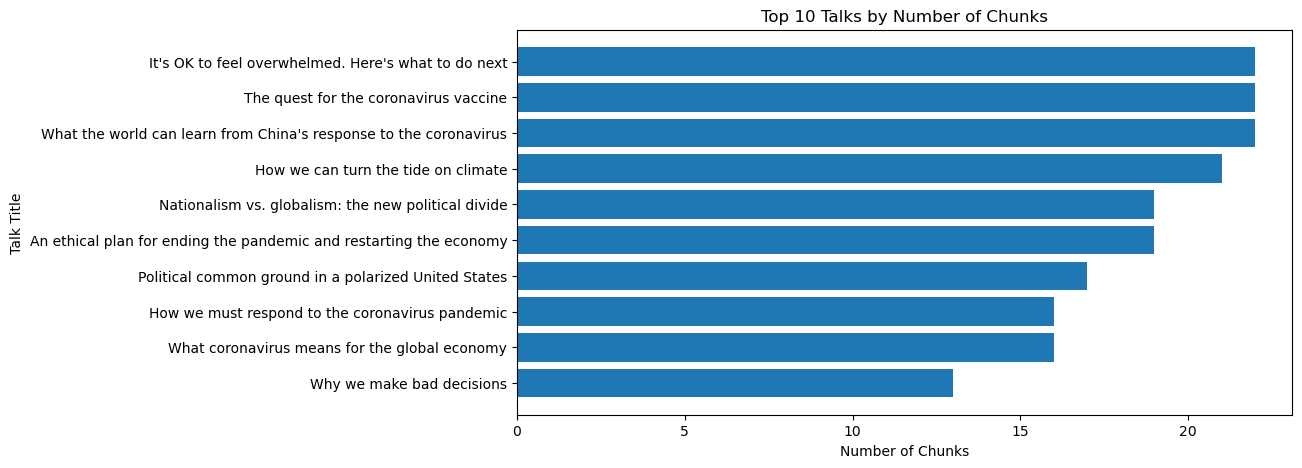

In [25]:
chunks_df = pd.read_csv(OUTPUT_CSV, usecols=["talk_id","title","n_chars"])
top_talks = chunks_df.groupby(["talk_id","title"]).size().reset_index(name="num_chunks")
top_talks = top_talks.sort_values("num_chunks", ascending=False).head(10)

plt.figure(figsize=(10,5))
plt.barh(top_talks["title"], top_talks["num_chunks"])
plt.gca().invert_yaxis()
plt.xlabel("Number of Chunks")
plt.ylabel("Talk Title")
plt.title("Top 10 Talks by Number of Chunks")
plt.show()


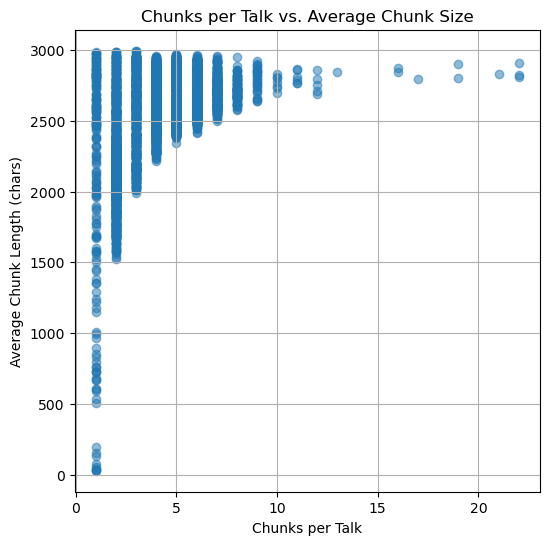

In [26]:
talk_stats = chunks_df.groupby("talk_id").agg(
    chunks_per_talk=("n_chars", "count"),
    avg_chars_per_chunk=("n_chars", "mean")
)

plt.figure(figsize=(6,6))
plt.scatter(talk_stats["chunks_per_talk"], talk_stats["avg_chars_per_chunk"], alpha=0.5)
plt.xlabel("Chunks per Talk")
plt.ylabel("Average Chunk Length (chars)")
plt.title("Chunks per Talk vs. Average Chunk Size")
plt.grid(True)
plt.show()
